<a href="https://colab.research.google.com/github/skarskar/KafkaLambda/blob/main/capstone-project/Capstone_Loan_Default_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
!pip install category_encoders
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 5.3 MB/s eta 0:00:00


In [113]:
# mlp for binary classification
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from scipy.stats.mstats import winsorize
from category_encoders import TargetEncoder
from feature_engine.outliers import Winsorizer
%matplotlib inline

In [47]:
%time
# Set your environment in a notebook:
# Set the Environment
# Ignore Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Write out the versions of all packages to requirements.txt
!pip freeze >> requirements.txt

# Remove the restriction on Jupyter that limits the columns displayed (the ... in the middle)
# pd.set_option('max_columns',None)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html#

# Pretty Display of variables.  for instance, you can call df.head() and df.tail() in the same cell and BOTH display w/o print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# List of ALL Magic Commands.  To run a magic command %var  --- i.e.:  %env
%lsmagic
# %env  -- list environment variables
# %%time  -- gives you information about how long a cel took to run
# %%timeit -- runs a cell 100,000 times and then gives you the average time the cell will take to run (can be LONG)
# %pdb -- python debugger

# to display nice model diagram
from sklearn import set_config
set_config(display='diagram')

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow
print("\n tensorflow: " + tensorflow.__version__)

print("\n Numpy: " + np.__version__)
print("\n sklearn: " + sklearn.__version__)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%late


 tensorflow: 2.12.0

 Numpy: 1.23.5

 sklearn: 1.2.2


In [83]:
'''
ID: unique ID of representative
Loan Amount: loan amount applied
Funded Amount:The total amount committed to that loan at that point in time.
Funded Amount Investor: The total amount committed by investors for that loan at that point in time.
Term: term of loan (in months)
Batch Enrolled: batch numbers to representatives
Interest Rate: interest rate (%) on loan
Grade: grade by the bank
Sub Grade: sub-grade by the bank
Debit to Income: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage
Delinquency - two years: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
Inquires - six months: total number of inquiries in last 6 months
Open Account: number of open credit line in representative's - credit line
Public Record: number of derogatory public records
Revolving Balance: total credit revolving balance
Revolving Utilities: amount of credit a representative is using - relative to revolving_balance
Total Accounts: total number of credit lines available in - representatives credit line
Initial List Status: unique listing status of the loan - - W(Waiting), F(Forwarded)
Total Received Interest: total interest received till date
Total Received Late Fee: total late fee received till date
Recoveries: post charge off gross recovery
Collection Recovery Fee: post charge off collection fee
Collection 12 months Medical: total collections in last 12 months - excluding medical collections
Application Type: indicates when the representative is an individual or joint
Last week Pay: indicates how long (in weeks) a representative has paid EMI after batch enrolled
Accounts Delinquent: number of accounts on which the representative is delinquent
Total Collection Amount: total collection amount ever owed
Total Current Balance: total current balance from all accounts
Total Revolving Credit Limit: total revolving credit limit
Loan Status: 1 = Defaulter, 0 = Non Defaulters
verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
Home Ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
'''

path = 'https://raw.githubusercontent.com/skarskar/MLWorkshop/main/dataset/Loan%20Default%20prediction%20dataset%20Train.csv'
df= read_csv(path)
df.head(5)


"\nID: unique ID of representative\nLoan Amount: loan amount applied\nFunded Amount:The total amount committed to that loan at that point in time.\nFunded Amount Investor: The total amount committed by investors for that loan at that point in time.\nTerm: term of loan (in months)\nBatch Enrolled: batch numbers to representatives\nInterest Rate: interest rate (%) on loan\nGrade: grade by the bank\nSub Grade: sub-grade by the bank\nDebit to Income: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage\nDelinquency - two years: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years \nInquires - six months: total number of inquiries in last 6 months\nOpen Account: number of open credit line in representative's - credit line\nPublic Record: number of derogatory public records\nRevolving Balance: total credit revolving balance\nRevolving Utilities: amount of credit a representati

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [41]:
cols = [i for i in cate if df[i].nunique()>5]
cols

['Batch Enrolled', 'Grade', 'Sub Grade', 'Loan Title']

In [ ]:
encoder = TargetEncoder()
df['loan_title_encoded_sklearn'] = encoder.fit_transform(df['loan_title'], df['loan_default_status'])
df['loan_title_encoded_sklearn']

In [34]:
for feature in cols:
    g = dict(df.groupby(feature)['Loan Status'].mean())
    df[feature] = df[feature].replace(g)

{'BAT1104812': 0.09979973297730307, 'BAT1135695': 0.125, 'BAT1184694': 0.0835509138381201, 'BAT1467036': 0.09102244389027432, 'BAT1586599': 0.10502864417568428, 'BAT1761981': 0.1040268456375839, 'BAT1766061': 0.08487337440109514, 'BAT1780517': 0.09945900957136912, 'BAT1930365': 0.09490238611713665, 'BAT2003848': 0.10807600950118765, 'BAT2078974': 0.09126637554585153, 'BAT2136391': 0.09217877094972067, 'BAT224923': 0.09944134078212291, 'BAT2252229': 0.09307782557684786, 'BAT2333412': 0.0856338028169014, 'BAT2428731': 0.09227467811158799, 'BAT2522922': 0.09506790564689063, 'BAT2558388': 0.09577177789098319, 'BAT2575549': 0.09437306158617634, 'BAT2803411': 0.08824742268041237, 'BAT2833642': 0.08655876143560873, 'BAT3193689': 0.08744635193133048, 'BAT3461431': 0.08426966292134831, 'BAT3726927': 0.07835400225479143, 'BAT3865626': 0.0782967032967033, 'BAT3873588': 0.09376723662437948, 'BAT4136152': 0.08380520951302378, 'BAT4271519': 0.09444985394352483, 'BAT4351734': 0.09473684210526316, 'BA

In [ ]:
df.info()

In [ ]:
df.nunique()

In [ ]:
df.isna().sum()

# Preprocessing
## split data into train, validation & test at the earliest so that bias is not introduced.

In [84]:
df.rename(columns={'Loan Status': 'Loan Default Status', 'Employment Duration': 'Home Ownership','Home Ownership':'Annual Income'}, inplace=True)

#drop columns as these only have 1 unique value
df.drop(columns=['Payment Plan','Accounts Delinquent'], inplace=True)
df.drop(columns=['ID'], inplace=True)

In [85]:
# change columns & categorical column values to lower case and replace space with hyphen
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
df.head(1).T

,0
loan_amount,10000
funded_amount,32236
funded_amount_investor,12329.36286
term,59
batch_enrolled,bat2522922
interest_rate,11.135007
grade,b
sub_grade,c4
home_ownership,mortgage
annual_income,176346.6267


In [86]:
#check for duplicates
df.drop_duplicates(inplace=True)

In [87]:
# Select object type data and numerical data columns seperately
cate = [i for i in df.select_dtypes(include='object').columns]
num = [i for i in df.select_dtypes(exclude='object').columns]
print(cate)
print(num)

['batch_enrolled', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_title', 'initial_list_status', 'application_type']
['loan_amount', 'funded_amount', 'funded_amount_investor', 'term', 'interest_rate', 'annual_income', 'debit_to_income', 'delinquency_-_two_years', 'inquires_-_six_months', 'open_account', 'public_record', 'revolving_balance', 'revolving_utilities', 'total_accounts', 'total_received_interest', 'total_received_late_fee', 'recoveries', 'collection_recovery_fee', 'collection_12_months_medical', 'last_week_pay', 'total_collection_amount', 'total_current_balance', 'total_revolving_credit_limit', 'loan_default_status']


In [88]:
df[num].drop(columns='loan_default_status').describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amount,67463.0,16848.902776,8367.865726,1014.000000,10012.000000,16073.000000,22106.000000,3.500000e+04
funded_amount,67463.0,15770.599114,8150.992662,1014.000000,9266.500000,13042.000000,21793.000000,3.499900e+04
funded_amount_investor,67463.0,14621.799323,6785.345170,1114.590204,9831.684984,12793.682170,17807.594120,3.499975e+04
term,67463.0,58.173814,3.327441,36.000000,58.000000,59.000000,59.000000,5.900000e+01
interest_rate,67463.0,11.846258,3.718629,5.320006,9.297147,11.377696,14.193533,2.718235e+01
annual_income,67463.0,80541.502522,45029.120366,14573.537170,51689.843335,69335.832680,94623.322785,4.065615e+05
debit_to_income,67463.0,23.299241,8.451824,0.675299,16.756416,22.656658,30.048400,3.962986e+01
delinquency_-_two_years,67463.0,0.327127,0.800888,0.000000,0.000000,0.000000,0.000000,8.000000e+00
inquires_-_six_months,67463.0,0.145754,0.473291,0.000000,0.000000,0.000000,0.000000,5.000000e+00
open_account,67463.0,14.266561,6.225060,2.000000,10.000000,13.000000,16.000000,3.700000e+01


In [ ]:
## Outliers
# iterate over the numeric columns in the DataFrame and plot a boxplot for each column
for col in df.drop(columns='loan_default_status').select_dtypes(exclude=['object']).columns:
    #fig, (ax1) = plt.subplots(1,2,1, figsize=(3,3))
      plt.figure(figsize=(12,6))
      plt.subplot(1,2,1)
      sns.boxplot(data=df[col])
      plt.title(col)

      plt.subplot(1,2,2)
      sns.distplot(df[col], kde=True)
      plt.title(col)
      plt.show()

In [ ]:
for col in df.drop(columns='loan_default_status').select_dtypes(exclude=['object']).columns:
  plt.figure(figsize=(6,6))
  sns.boxplot(x='loan_default_status', y=col, data=df)

In [132]:
capper = Winsorizer(capping_method='quantiles',
                    tail='both',
                    fold=3,
                    variables=['funded_amount_investor', 'interest_rate',
                               'annual_income', 'open_account', 'total_accounts'])
capper.fit(df)
print(capper.right_tail_caps_)
print(capper.left_tail_caps_)
# transform the data
df = capper.transform(df)
df.head(10)

Winsorizer(capping_method='quantiles', fold=0.05, tail='both',
           variables=['funded_amount_investor', 'interest_rate',
                      'annual_income', 'open_account', 'total_accounts'])

{'funded_amount_investor': 28884.736112, 'interest_rate': 18.600114017, 'annual_income': 168296.71762999994, 'open_account': 29.0, 'total_accounts': 33.0}
{'funded_amount_investor': 6327.9797844, 'interest_rate': 6.1348234001, 'annual_income': 33448.72614600001, 'open_account': 7.0, 'total_accounts': 6.0}


,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,home_ownership,annual_income,verification_status,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_default_status,z_open_account
0,10000,32236,12329.362860,59,bat2522922,11.135007,b,c4,mortgage,168296.71763,not_verified,debt_consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,individual,49,31,311301,6619,0,-0.203462
1,3609,11940,12191.996920,59,bat1586599,12.237563,c,d3,rent,39833.92100,source_verified,debt_consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,individual,109,53,182610,20885,0,-0.364103
2,28276,9311,21603.224550,59,bat2136391,12.545884,f,d4,mortgage,91506.69105,source_verified,debt_consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,individual,66,34,89801,26155,0,-0.042821
3,11170,6954,17877.155850,59,bat2428731,16.731201,c,c3,mortgage,108286.57590,source_verified,debt_consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,individual,39,40,9189,60214,0,-1.167308
4,16890,13226,13539.926670,59,bat5341619,15.008300,c,d4,mortgage,44234.82545,source_verified,credit_card_refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,individual,18,430,126029,22579,0,-0.203462
5,34631,30203,8635.931613,36,bat4694572,17.246986,b,g5,rent,98957.47561,not_verified,credit_card_refinancing,7.914333,3,2,16,0,2277,51.564476,20,w,464.818124,0.088584,5.043575,0.581688,0,individual,32,42,51252,27480,0,0.278461
6,30844,19773,15777.511830,59,bat4808022,10.731432,c,c5,rent,102391.82430,verified,home_improvement,15.083911,0,0,11,0,14501,46.808804,33,w,525.738109,0.083528,3.167937,0.553076,0,individual,71,3388,42069,31068,0,-0.524744
7,20744,10609,7645.014802,58,bat2558388,13.993688,a,a5,own,61723.52014,not_verified,debt_consolidation,29.829715,0,0,14,0,13067,23.936624,33,w,1350.245212,0.044965,0.098448,0.047589,0,individual,87,48,184909,43303,0,-0.042821
8,9299,11238,13429.456610,59,bat5341619,11.178457,g,c2,mortgage,63205.09072,verified,credit_card_refinancing,26.244710,0,0,7,0,549,15.947386,17,w,4140.198978,0.017106,0.530214,0.216985,0,individual,144,26,68126,7482,0,-1.327949
9,19232,8962,7004.097481,58,bat2078974,6.134823,c,b5,rent,42015.46586,source_verified,credit_card_refinancing,10.048549,1,0,11,0,1361,35.073345,30,f,2149.666963,0.008338,2.912215,0.886864,0,individual,9,35,71650,14871,0,-0.524744


In [91]:
df['open_account'].describe()

count    67463.000000
mean        14.266561
std          6.225060
min          2.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         37.000000
Name: open_account, dtype: float64

In [78]:
len(df['open_account'][df['open_account'] > 25.0])

5614

In [92]:
Q1=df["open_account"].quantile(0.25)
Q1

10.0

In [93]:
Q3=df["open_account"].quantile(0.75)
Q3

16.0

In [94]:
IQR = Q3 - Q1
IQR

6.0

In [95]:
lower_lim = Q1 - IQR * 1.5
lower_lim

1.0

In [96]:
upper_lim =  Q3 + IQR * 1.5
upper_lim

25.0

In [97]:
len(df['open_account'][((df['open_account'] < lower_lim) | (df['open_account'] > upper_lim))])

5614

In [98]:
df['z_open_account']=(df['open_account'] - df['open_account'].mean())/df['open_account'].std()
df.head(5)

,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,home_ownership,annual_income,verification_status,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_default_status,z_open_account
0,10000,32236,12329.36286,59,bat2522922,11.135007,b,c4,mortgage,176346.62670,not_verified,debt_consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,individual,49,31,311301,6619,0,-0.203462
1,3609,11940,12191.99692,59,bat1586599,12.237563,c,d3,rent,39833.92100,source_verified,debt_consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,individual,109,53,182610,20885,0,-0.364103
2,28276,9311,21603.22455,59,bat2136391,12.545884,f,d4,mortgage,91506.69105,source_verified,debt_consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,individual,66,34,89801,26155,0,-0.042821
3,11170,6954,17877.15585,59,bat2428731,16.731201,c,c3,mortgage,108286.57590,source_verified,debt_consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,individual,39,40,9189,60214,0,-1.167308
4,16890,13226,13539.92667,59,bat5341619,15.008300,c,d4,mortgage,44234.82545,source_verified,credit_card_refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,individual,18,430,126029,22579,0,-0.203462


In [100]:
df_open_account_filtered= df[(df['z_open_account']>-3) & (df['z_open_account']<3)]

print(len(df_open_account_filtered))

66141


In [105]:
df[df.loan_default_status==0].head(10)

,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,home_ownership,annual_income,verification_status,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_default_status,z_open_account
0,10000,32236,12329.362860,59,bat2522922,11.135007,b,c4,mortgage,176346.62670,not_verified,debt_consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,individual,49,31,311301,6619,0,-0.203462
1,3609,11940,12191.996920,59,bat1586599,12.237563,c,d3,rent,39833.92100,source_verified,debt_consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,individual,109,53,182610,20885,0,-0.364103
2,28276,9311,21603.224550,59,bat2136391,12.545884,f,d4,mortgage,91506.69105,source_verified,debt_consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,individual,66,34,89801,26155,0,-0.042821
3,11170,6954,17877.155850,59,bat2428731,16.731201,c,c3,mortgage,108286.57590,source_verified,debt_consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,individual,39,40,9189,60214,0,-1.167308
4,16890,13226,13539.926670,59,bat5341619,15.008300,c,d4,mortgage,44234.82545,source_verified,credit_card_refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,individual,18,430,126029,22579,0,-0.203462
5,34631,30203,8635.931613,36,bat4694572,17.246986,b,g5,rent,98957.47561,not_verified,credit_card_refinancing,7.914333,3,2,16,0,2277,51.564476,20,w,464.818124,0.088584,5.043575,0.581688,0,individual,32,42,51252,27480,0,0.278461
6,30844,19773,15777.511830,59,bat4808022,10.731432,c,c5,rent,102391.82430,verified,home_improvement,15.083911,0,0,11,0,14501,46.808804,37,w,525.738109,0.083528,3.167937,0.553076,0,individual,71,3388,42069,31068,0,-0.524744
7,20744,10609,7645.014802,58,bat2558388,13.993688,a,a5,own,61723.52014,not_verified,debt_consolidation,29.829715,0,0,14,0,13067,23.936624,33,w,1350.245212,0.044965,0.098448,0.047589,0,individual,87,48,184909,43303,0,-0.042821
8,9299,11238,13429.456610,59,bat5341619,11.178457,g,c2,mortgage,63205.09072,verified,credit_card_refinancing,26.244710,0,0,6,0,549,15.947386,17,w,4140.198978,0.017106,0.530214,0.216985,0,individual,144,26,68126,7482,0,-1.327949
9,19232,8962,7004.097481,58,bat2078974,5.520413,c,b5,rent,42015.46586,source_verified,credit_card_refinancing,10.048549,1,0,11,0,1361,35.073345,30,f,2149.666963,0.008338,2.912215,0.886864,0,individual,9,35,71650,14871,0,-0.524744


In [ ]:
sns.boxplot(x='loan_default_status', y='open_account', data=df)

In [123]:
capper = Winsorizer(capping_method='quantiles',
                    tail='both',
                    fold=3,
                    variables=['funded_amount_investor', 'interest_rate',
                               'annual_income', 'open_account', 'total_accounts'])
capper.fit(df)
capper.right_tail_caps_

Winsorizer(capping_method='quantiles', fold=0.05, tail='both',
           variables=['funded_amount_investor', 'interest_rate',
                      'annual_income', 'open_account', 'total_accounts'])

{'funded_amount_investor': 28884.736112,
 'interest_rate': 18.600114017,
 'annual_income': 168296.71762999994,
 'open_account': 29.0,
 'total_accounts': 33.0}

In [124]:
# transform the data
df_new = capper.transform(df)
df_new.head()

,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,home_ownership,annual_income,verification_status,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_default_status,z_open_account
0,10000,32236,12329.36286,59,bat2522922,11.135007,b,c4,mortgage,168296.71763,not_verified,debt_consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,individual,49,31,311301,6619,0,-0.203462
1,3609,11940,12191.99692,59,bat1586599,12.237563,c,d3,rent,39833.92100,source_verified,debt_consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,individual,109,53,182610,20885,0,-0.364103
2,28276,9311,21603.22455,59,bat2136391,12.545884,f,d4,mortgage,91506.69105,source_verified,debt_consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,individual,66,34,89801,26155,0,-0.042821
3,11170,6954,17877.15585,59,bat2428731,16.731201,c,c3,mortgage,108286.57590,source_verified,debt_consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,individual,39,40,9189,60214,0,-1.167308
4,16890,13226,13539.92667,59,bat5341619,15.008300,c,d4,mortgage,44234.82545,source_verified,credit_card_refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,individual,18,430,126029,22579,0,-0.203462


In [80]:
# winsorize
# df['total_current_balance'] = pd.DataFrame(winsorize(df['total_current_balance'],(0.0,0.04)))[0]
# df['funded_amount_investors'] = pd.DataFrame(winsorize(df['funded_amount_investors'],(0.0,0.05)))[0]
# df['total_received_interest'] = pd.DataFrame(winsorize(df['total_received_interest'],(0.0,0.08)))[0]
df_table_win = winsorize(df['open_account'],(0.0,0.08))  # lower boundary 1% - upper boundary (1-0.02) or 98th percentile or higher
df_table_win

masked_array(data=[13, 12, 14, ...,  7, 14, 26],
             mask=False,
       fill_value=999999)

<Axes: >

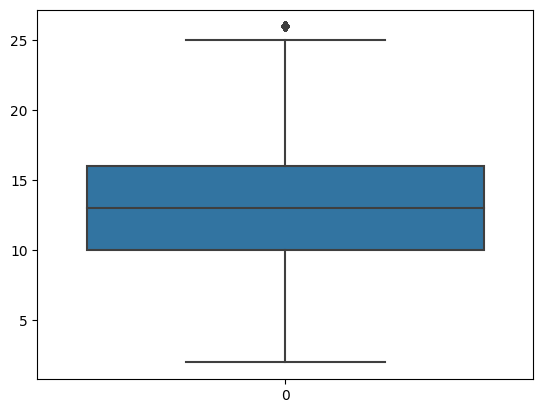

In [81]:
sns.boxplot(data=df_table_win)

In [82]:
df_table_win = pd.DataFrame(df_table_win)[0]
df_table_win.describe()
df['total_received_interest'] = pd.DataFrame(winsorize(df['total_received_interest'],(0.0,0.08)))[0]

count    67463.000000
mean        13.924462
std          5.337023
min          2.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         26.000000
Name: 0, dtype: float64

<Axes: >

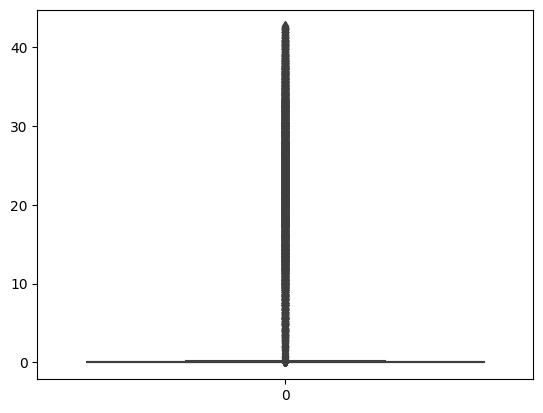

In [175]:
sns.boxplot(data=df['total_received_late_fee'])

In [185]:
# prepare input data
def prepare_inputs(X_train, X_test):
  #https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69
 #oe = ce.CountEncoder()
 #oe.fit(X_train)
 X_train_enc = pd.get_dummies(X_train) #oe.transform(X_train)
 X_test_enc = pd.get_dummies(X_test)  #oe.transform(X_test)
 return X_train_enc, X_test_enc

In [186]:
# prepare target
def prepare_targets(y_train, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc

In [187]:
# feature selection based on chi2
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=chi2, k=1)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

In [188]:
# feature selection based on Mutual Importance
def select_features_mutual_info(X_train, y_train, X_test):
 fs = SelectKBest(score_func=mutual_info_classif, k=1)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

In [189]:
# split into train and test sets
df_X_train_test = df.drop(columns='loan_status').to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(df_X_train_test)
dv.get_feature_names_out()
X = dv.transform(df_X_train_test)
X_train, X_test = train_test_split(X, test_size=0.20, random_state=10)
y_train, y_test = train_test_split(df.loan_status, test_size=0.20, random_state=10)

#X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
#y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

DictVectorizer(sparse=False)

array(['batch_enrolled=bat1104812', 'batch_enrolled=bat1135695',
       'batch_enrolled=bat1184694', 'batch_enrolled=bat1467036',
       'batch_enrolled=bat1586599', 'batch_enrolled=bat1761981',
       'batch_enrolled=bat1766061', 'batch_enrolled=bat1780517',
       'batch_enrolled=bat1930365', 'batch_enrolled=bat2003848',
       'batch_enrolled=bat2078974', 'batch_enrolled=bat2136391',
       'batch_enrolled=bat224923', 'batch_enrolled=bat2252229',
       'batch_enrolled=bat2333412', 'batch_enrolled=bat2428731',
       'batch_enrolled=bat2522922', 'batch_enrolled=bat2558388',
       'batch_enrolled=bat2575549', 'batch_enrolled=bat2803411',
       'batch_enrolled=bat2833642', 'batch_enrolled=bat3193689',
       'batch_enrolled=bat3461431', 'batch_enrolled=bat3726927',
       'batch_enrolled=bat3865626', 'batch_enrolled=bat3873588',
       'batch_enrolled=bat4136152', 'batch_enrolled=bat4271519',
       'batch_enrolled=bat4351734', 'batch_enrolled=bat4694572',
       'batch_enrolled=bat

In [190]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
print(fs.n_features_in_)
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
#plt.plot([i for i in range(len(fs.scores_))], fs.scores_)
#plt.show()

189
Feature 0: 4.392089
Feature 1: 2.125490
Feature 2: 0.639292
Feature 3: 0.034101
Feature 4: 5.342822
Feature 5: 2.485707
Feature 6: 0.350014
Feature 7: 1.164590
Feature 8: 0.076004
Feature 9: 1.178240
Feature 10: 0.640525
Feature 11: 0.003640
Feature 12: 1.756468
Feature 13: 0.019340
Feature 14: 1.772386
Feature 15: 0.105941
Feature 16: 0.887497
Feature 17: 0.150229
Feature 18: 0.000056
Feature 19: 0.696748
Feature 20: 0.034144
Feature 21: 0.231547
Feature 22: 0.302574
Feature 23: 5.677502
Feature 24: 1.301385
Feature 25: 0.062678
Feature 26: 2.135340
Feature 27: 0.072473
Feature 28: 0.167567
Feature 29: 0.890870
Feature 30: 0.024623
Feature 31: 0.215704
Feature 32: 0.414084
Feature 33: 1.650563
Feature 34: 0.010018
Feature 35: 0.118231
Feature 36: 0.110529
Feature 37: 0.561167
Feature 38: 0.053132
Feature 39: 0.456168
Feature 40: 1.339699
Feature 41: 10.052007
Feature 42: 2.569983
Feature 43: 3.649431
Feature 44: 3.389342
Feature 45: 1.838547
Feature 46: 683.528559
Feature 47: 970.

In [191]:
#Accuracy Score
model = LogisticRegression(solver='liblinear', random_state=12)
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

LogisticRegression(random_state=12, solver='liblinear')

Accuracy: 90.85


In [192]:
#Accuracy Score Based on Chi2
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
print(fs.get_feature_names_out())
print(fs.get_support(indices=True))
# fit the model
model1 = LogisticRegression(solver='liblinear', random_state=12)
model1.fit(X_train_fs, y_train)
# evaluate the model
yhat = model1.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))
print(model1.predict_proba(X_test_fs)[0,1])
print(model1.predict(X_test_fs)[:5])

['x55']
[55]


LogisticRegression(random_state=12, solver='liblinear')

Accuracy: 90.85
0.07217388870548991
[0 0 0 0 0]


In [193]:
#Accuracy Score based on Mutual Info
X_train_fs1, X_test_fs1, fs = select_features_mutual_info(X_train, y_train, X_test)
# fit the model
model2 = LogisticRegression(solver='liblinear', random_state=12)
model2.fit(X_train_fs1, y_train)
# evaluate the model
yhat = model2.predict(X_test_fs1)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

LogisticRegression(random_state=12, solver='liblinear')

Accuracy: 90.85


<Axes: >

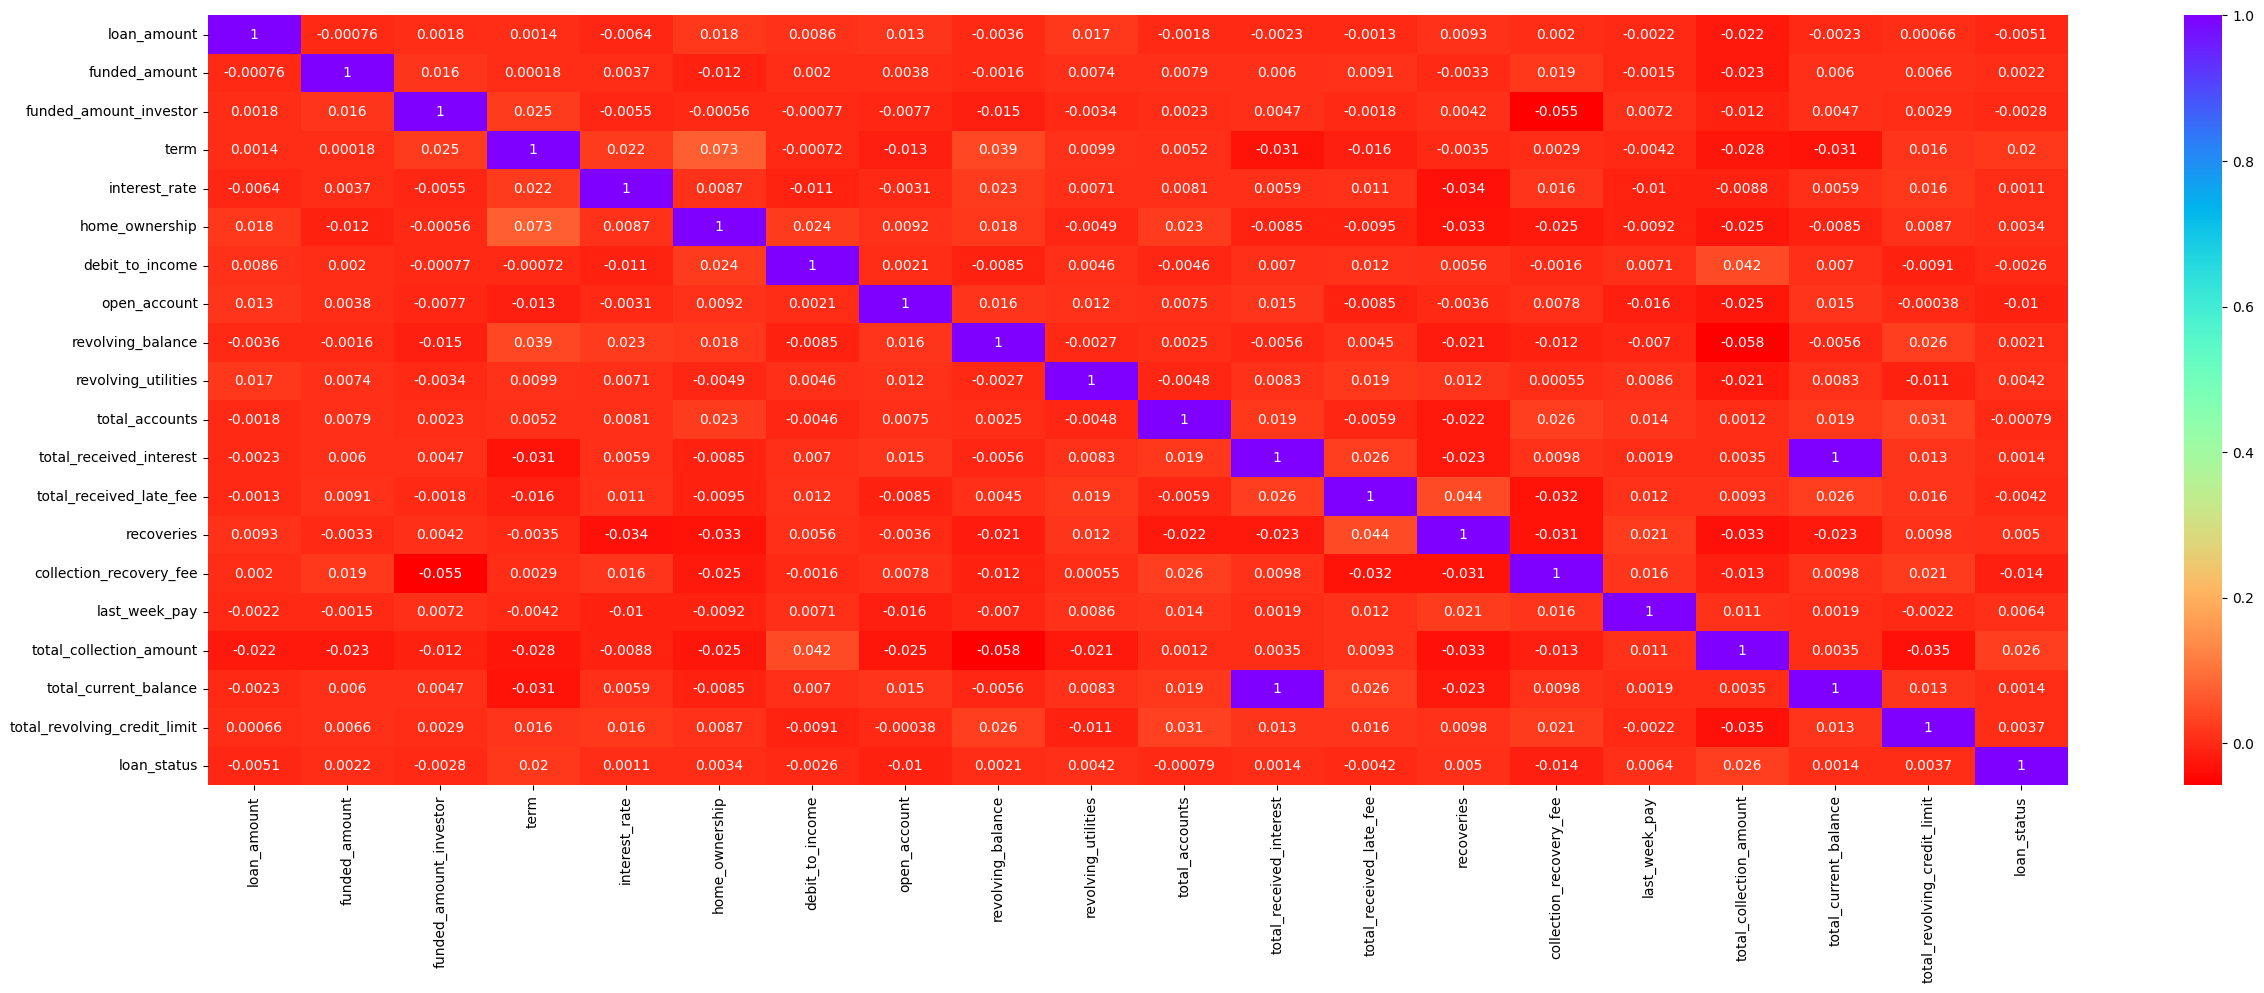

In [176]:
# correlation between y and features
##sns.set(rc={'figure.figsize':(30,10)})
#sns.set_context("talk", font_scale=0.7)
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(df.iloc[:].corr(method='spearman'), cmap='rainbow_r', annot=True)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


<Axes: >

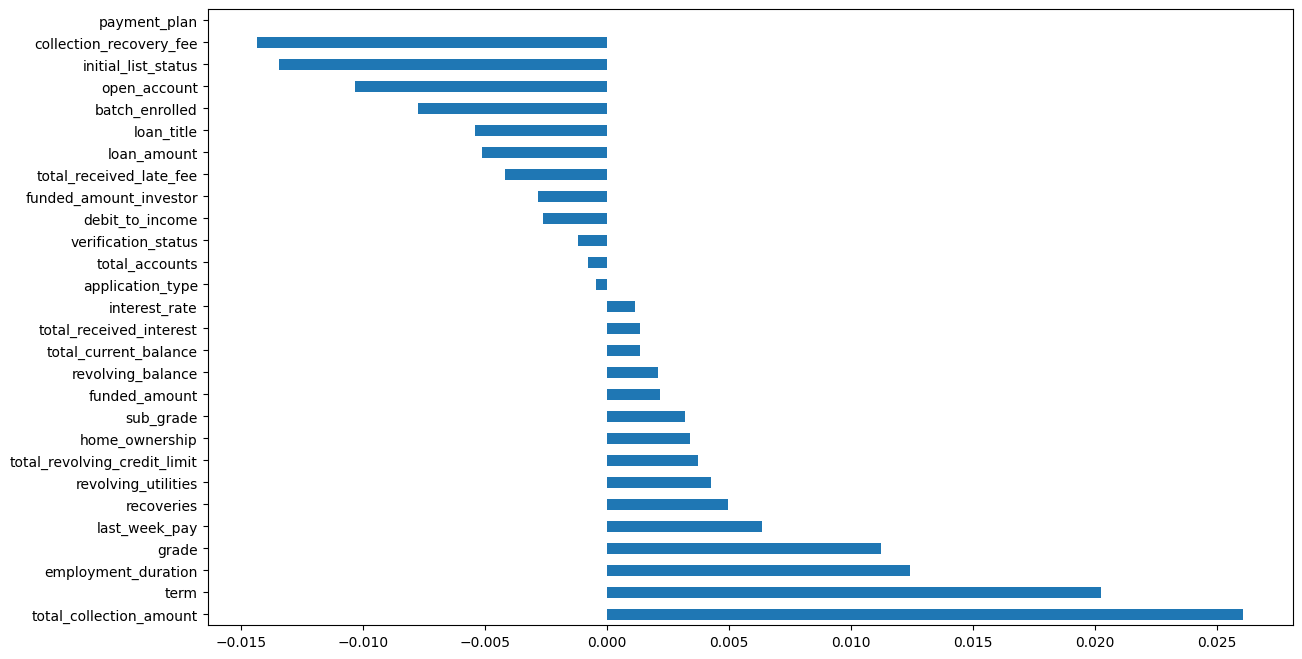

In [177]:
df.drop("loan_status", axis=1).apply(lambda x: x.corr(df.loan_status,method='spearman')).sort_values(ascending=False).plot(kind='barh', figsize=(14,8))

In [178]:
#distribution of the target. There is data imbalance
# Resample is required
df.loan_status.value_counts().reset_index()

,index,loan_status
0,0,61222
1,1,6241


In [179]:
# Rebalancing is required as bias toward Non-Defaulters
(6241/(6241+61222))*100

9.250996842713784

<Axes: title={'center': 'Target  Balance'}, xlabel='loan_status', ylabel='Relative Frequency'>

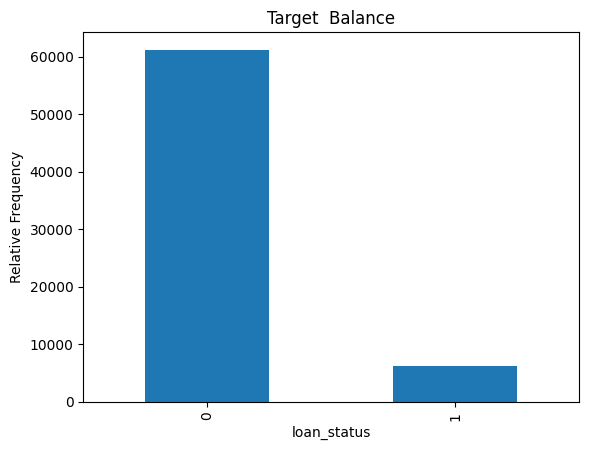

In [180]:
df["loan_status"].value_counts(normalize=False).plot(
    kind="bar", xlabel="loan_status", ylabel="Relative Frequency", title="Target  Balance"
)

In [181]:
global_loan_status_mean = df.loan_status.mean()
global_loan_status_mean

0.09250996842713784

In [182]:
#Categorical unique values
df.select_dtypes(include='object').nunique()

batch_enrolled         41
grade                   7
sub_grade              35
employment_duration     3
verification_status     3
payment_plan            1
loan_title             83
initial_list_status     2
application_type        2
dtype: int64

## Feature Importance/Selection based on Risk Ratio

In [183]:
#Mutual Information - https://triveratechvirtual6x.my.webex.com/recordingservice/sites/triveratechvirtual6x.my/recording/ccb27c09288d103cbbfdf2d7f7787d99/playback
# Does Category mean vary widely from global mean?

for col in df.select_dtypes(include='object').columns:
    df_group = df.groupby(by=col).loan_status.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_loan_status_mean

    #Risk Ratio. Higher risk to default if ratio is significantly >1
    df_group['risk'] = df_group['mean'] / global_loan_status_mean
    df_group['count'] = df[col].value_counts()
    display(df_group)

,mean,diff,risk,count
batch_enrolled,,,,
bat1104812,0.099800,0.007290,1.078800,2996
bat1135695,0.125000,0.032490,1.351206,296
bat1184694,0.083551,-0.008959,0.903156,2298
bat1467036,0.091022,-0.001488,0.983920,802
bat1586599,0.105029,0.012519,1.135322,3142
bat1761981,0.104027,0.011517,1.124493,894
bat1766061,0.084873,-0.007637,0.917451,1461
bat1780517,0.099459,0.006949,1.075117,2403
bat1930365,0.094902,0.002392,1.025861,1844


,mean,diff,risk,count
grade,,,,
a,0.091248,-0.001262,0.986363,12055
b,0.087237,-0.005273,0.943003,18742
c,0.093896,0.001386,1.014980,19085
d,0.096380,0.003870,1.041831,8259
e,0.095873,0.003363,1.036358,6446
f,0.103740,0.011230,1.121392,2246
g,0.106349,0.013839,1.149597,630


,mean,diff,risk,count
sub_grade,,,,
a1,0.091642,-0.000868,0.990620,1364
a2,0.097986,0.005476,1.059192,1837
a3,0.094362,0.001852,1.020020,1685
a4,0.091431,-0.001079,0.988338,2264
a5,0.094068,0.001558,1.016840,3540
b1,0.099863,0.007353,1.079486,2924
b2,0.088920,-0.003590,0.961199,3520
b3,0.082521,-0.009989,0.892019,3999
b4,0.091887,-0.000623,0.993266,4462


,mean,diff,risk,count
employment_duration,,,,
mortgage,0.088663,-0.003847,0.958419,36351
own,0.101551,0.009041,1.097733,6962
rent,0.095694,0.003184,1.034414,24150


,mean,diff,risk,count
verification_status,,,,
not_verified,0.092116,-0.000394,0.995738,16349
source_verified,0.093383,0.000873,1.009437,33036
verified,0.091271,-0.001239,0.986609,18078


,mean,diff,risk,count
payment_plan,,,,
n,0.09251,0.0,1.0,67463


,mean,diff,risk,count
loan_title,,,,
bathroom,0.071429,-0.021081,0.772118,14
bill_consolidation,0.066667,-0.025843,0.720643,15
bill_payoff,0.250000,0.157490,2.702411,12
bills,0.500000,0.407490,5.404823,4
business,0.076503,-0.016007,0.826967,183
car_financing,0.140741,0.048231,1.521358,135
car_loan,0.000000,-0.092510,0.000000,9
card_consolidation,0.062500,-0.030010,0.675603,16
cards,0.142857,0.050347,1.544235,28


,mean,diff,risk,count
initial_list_status,,,,
f,0.096714,0.004204,1.045446,31164
w,0.088901,-0.003609,0.960983,36299


,mean,diff,risk,count
application_type,,,,
individual,0.092516,0.000006,1.000061,67340
joint,0.089431,-0.003079,0.966716,123


In [184]:
#Following features can be dropped
# initial_list_status, application_type, verification_status
df.drop(columns=['initial_list_status','application_type','verification_status'], axis=1, inplace=True)
df.head(5)

,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,employment_duration,home_ownership,payment_plan,loan_title,debit_to_income,open_account,revolving_balance,revolving_utilities,total_accounts,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,last_week_pay,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_status
0,10000,32236,12329.36286,59,bat2522922,11.135007,b,c4,mortgage,176346.62670,n,debt_consolidation,16.284758,13,24246,74.932551,7,2929.646315,0.102055,2.498291,0.793724,49,31,2929.646315,6619,0
1,3609,11940,12191.99692,59,bat1586599,12.237563,c,d3,rent,39833.92100,n,debt_consolidation,15.412409,12,812,78.297186,13,772.769385,0.036181,2.377215,0.974821,109,53,772.769385,20885,0
2,28276,9311,21603.22455,59,bat2136391,12.545884,f,d4,mortgage,91506.69105,n,debt_consolidation,28.137619,14,1843,2.073040,20,863.324396,18.778660,4.316277,1.020075,66,34,863.324396,26155,0
3,11170,6954,17877.15585,59,bat2428731,16.731201,c,c3,mortgage,108286.57590,n,debt_consolidation,18.043730,7,13819,67.467951,12,288.173196,0.044131,0.107020,0.749971,39,40,288.173196,60214,0
4,16890,13226,13539.92667,59,bat5341619,15.008300,c,d4,mortgage,44234.82545,n,credit_card_refinancing,17.209886,13,1544,85.250761,22,129.239553,19.306646,1294.818751,0.368953,18,430,129.239553,22579,0


## Data Preprocessing

In [ ]:
sns.countplot(x="Loan Status", data=df)

ValueError: ignored

<Axes: xlabel='Employment Duration', ylabel='count'>

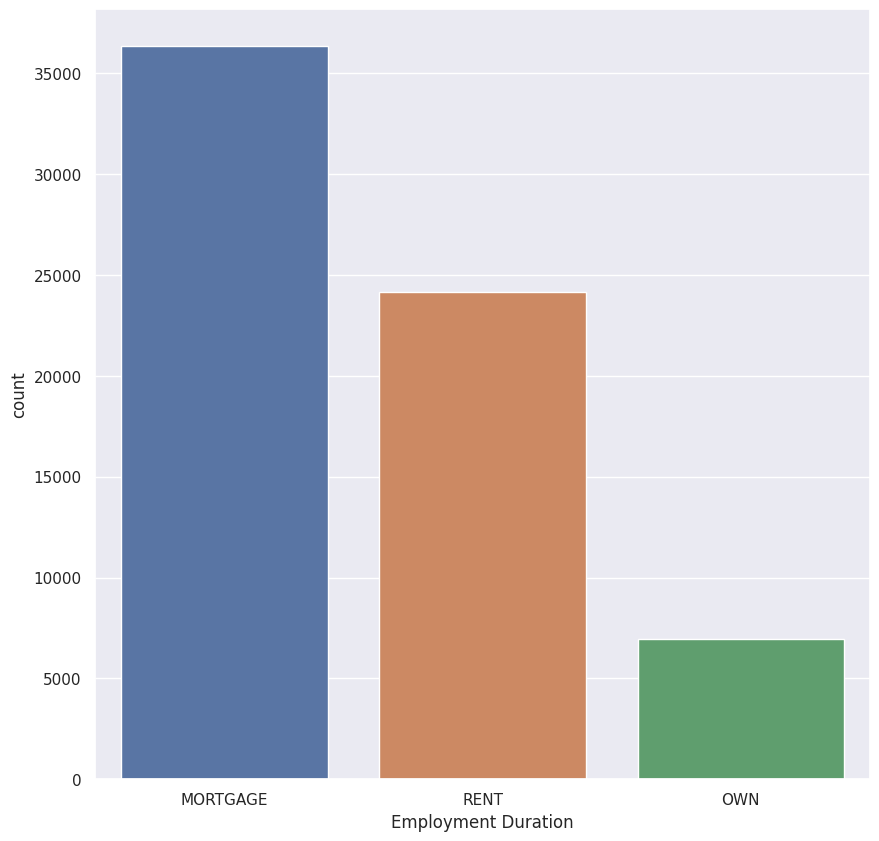

In [ ]:
df['Employment Duration'].value_counts()
sns.countplot(x="Employment Duration", data=df)



## Bivariate Analysis








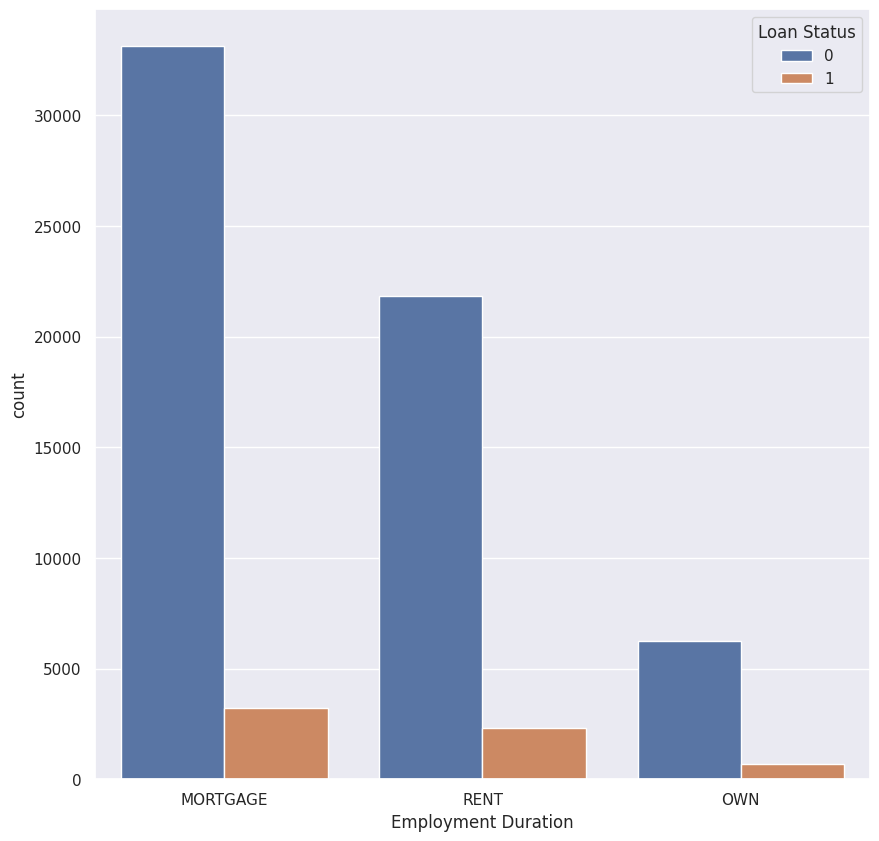

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
emp = sns.countplot(x='Employment Duration', hue='Loan Status', data=df)

plt.show()

Correlation Analysis

<ipython-input-28-1373cde3af3e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.iloc[:,1:].corr(method='pearson'), cmap='rainbow_r', annot=True)


<Axes: >

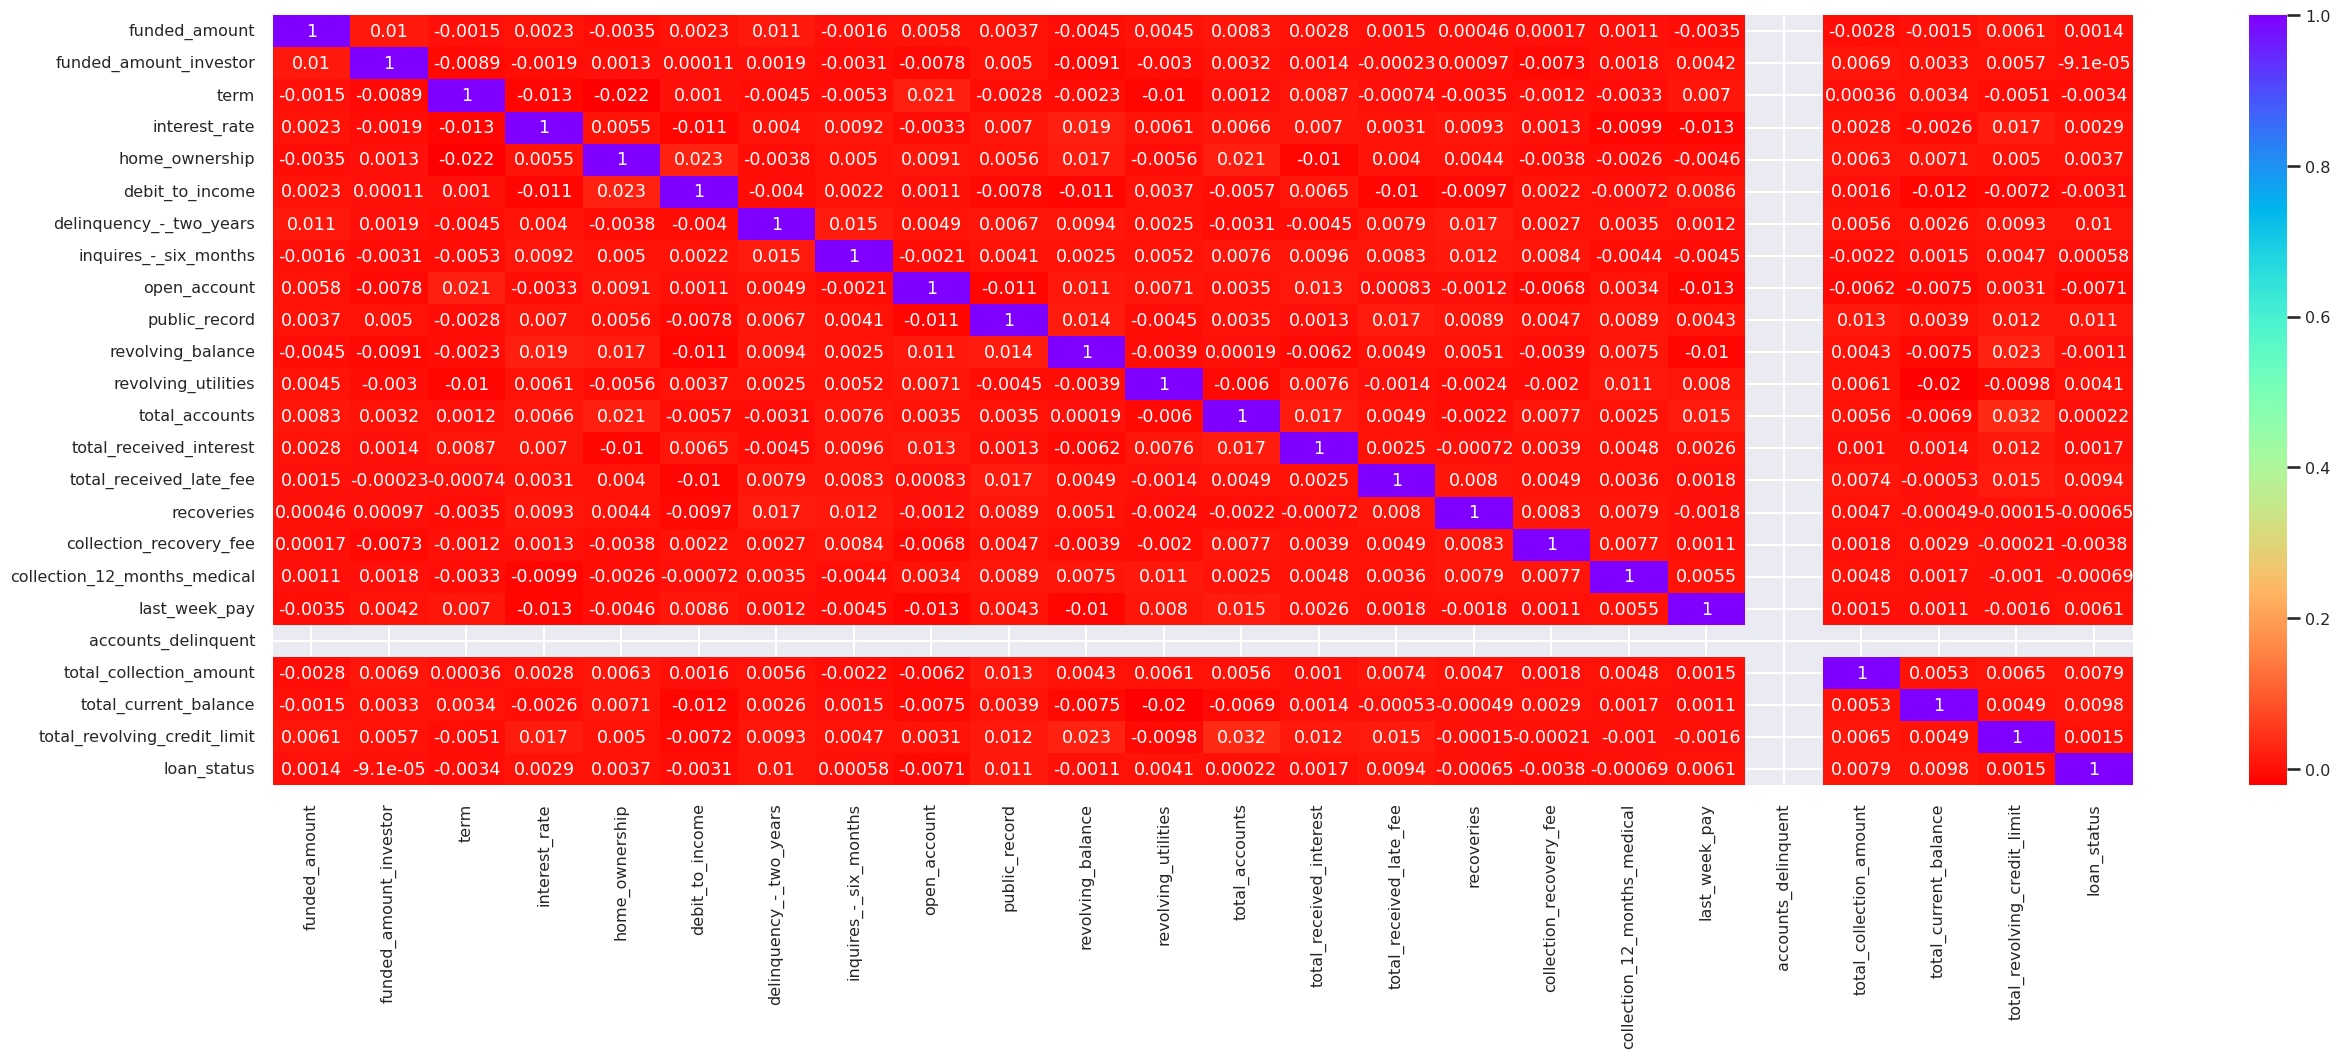

In [ ]:
sns.set(rc={'figure.figsize':(30,10)})
sns.set_context("talk", font_scale=0.7)
sns.heatmap(df.iloc[:,1:].corr(method='pearson'), cmap='rainbow_r', annot=True)

In [ ]:
#One-Hot Encoding of Categorical Column
cat=['Batch Enrolled',  'Grade','Sub Grade','Employment Duration',  'Verification Status', 'Payment Plan', 'Loan Title',  'Initial List Status',
     'Application Type']
df_encoded= pd.get_dummies(df, columns = cat)
df_encoded.head(5).T

,0,1,2,3,4
ID,6.508737e+07,1.450153e+06,1.969101e+06,6.651430e+06,1.435467e+07
Loan Amount,1.000000e+04,3.609000e+03,2.827600e+04,1.117000e+04,1.689000e+04
Funded Amount,3.223600e+04,1.194000e+04,9.311000e+03,6.954000e+03,1.322600e+04
Funded Amount Investor,1.232936e+04,1.219200e+04,2.160322e+04,1.787716e+04,1.353993e+04
Term,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01
...,...,...,...,...,...
Loan Title_vacation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Initial List Status_f,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Initial List Status_w,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Application Type_INDIVIDUAL,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# Modeling


In [ ]:
# split into input and output columns - you can split the data however you like
X, y = df_encoded.values[:, :-1], df_encoded.values[:, -1]

In [ ]:
# ensure all data are floating point values.  unique to this dataset only.  you want to make sure all are numeric and scaled
X = X.astype('float32')

In [ ]:
# encode strings to integer
y = LabelEncoder().fit_transform(y)

In [ ]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45200, 227) (22263, 227) (45200,) (22263,)


In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
X_train.shape

(45200, 227)

In [ ]:
# determine the number of input features
n_features = X_train.shape[1]

In [ ]:
n_features

227

In [ ]:
# Step 1: define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)

Epoch 1/150
1413/1413 [==============================] - 3s 2ms/step - loss: 3.6967 - accuracy: 0.9951
Epoch 2/150
1413/1413 [==============================] - 2s 1ms/step - loss: 1.2395 - accuracy: 0.9968
Epoch 3/150
1413/1413 [==============================] - 2s 1ms/step - loss: 0.3409 - accuracy: 0.9975
Epoch 4/150
1413/1413 [==============================] - 2s 2ms/step - loss: 0.0932 - accuracy: 0.9979
Epoch 5/150
1413/1413 [==============================] - 2s 2ms/step - loss: 0.0303 - accuracy: 0.9981
Epoch 6/150
1413/1413 [==============================] - 2s 1ms/step - loss: 0.0123 - accuracy: 0.9983
Epoch 7/150
1413/1413 [==============================] - 2s 2ms/step - loss: 0.0123 - accuracy: 0.9983
Epoch 8/150
1413/1413 [==============================] - 2s 1ms/step - loss: 0.0123 - accuracy: 0.9983
Epoch 9/150
1413/1413 [==============================] - 2s 1ms/step - loss: 0.0123 - accuracy: 0.9983
Epoch 10/150
1413/1413 [==============================] - 2s 1ms/step - l

In [ ]:
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.998
